<a href="https://colab.research.google.com/github/ttury/Do_It_For_Deep-Learning/blob/main/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

cancer_dataset = load_breast_cancer()
x = cancer_dataset.data
y = cancer_dataset.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)
x_train_scaled = (x_train - train_mean) / train_std
x_val_scaled = (x_val - train_mean) / train_std
x_test_scaled = (x_test - train_mean) / train_std

In [26]:
class SingleLayer:

  def __init__(self, _learning_rate = 0.1, _l1 = 0, _l2 = 0):
    self.w = None
    self.b = None
    self.losses = list() # 에포크마다 손실 함수 평균값
    self.val_losses = list() # 에포크마다 검증 세트 손실 함수 평균값
    self.w_history = list() # 가중치의 변화 과정 저장
    self.learning_rate = _learning_rate # 학습률 : 하이퍼마라미터, 가중치의 업데이트 양 조절
    self.l1 = _l1
    self.l2 = _l2

  def forpass(self, x_i):
    z = np.sum(self.w * x_i) + self.b # 하나의 값
    return z

  def backprop(self, x_i, err):
    w_grad = x_i * err # 다차원 벡터
    b_grad = 1 * err # 하나의 값
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None) # 최솟값 -100, 최댓값 x
    a = 1 / (1 + np.exp(-z)) # 시그모이드 계산
    return a
  
  def logistic_loss(self, y_i, a):
    return -(y_i * np.log(a) + (1-y_i) * np.log(1-a)) # 로지스틱 손실 함수 값 구하기

  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    self.w = np.ones(x.shape[1]) # 열 개수(특성 개수)
    self.b = 0
    self.w_history.append(self.w.copy()) # ndarray를 복사할때 = 사용 x, copy 함수 사용
    np.random.seed(42)

    for _ in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))
      '''
      에포크마다 훈련 세트를 무작위로 섞어 손실 함수의 값을 줄임
      arrange 함수 : 0 부터 len(x) - 1까지 1씩 커지는 array 생성
      permutation 함수 : array를 무작위로 섞음(실제 array 값에는 변화 없음)
      '''

      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.backprop(x[i], err)
        w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w # l1, l2 규제 모두 적용(가중치를 규제하기 위한 미분값)

        self.w -= w_grad * self.learning_rate
        self.b -= b_grad
        self.w_history.append(self.w.copy()) # 변화한 가중치 기록

        a = np.clip(a, 1e-10, 1-1e-10) # (10의 -10승) ~ (1 - 10의 -10승) 범위
        loss += self.logistic_loss(y[i], a)

      self.losses.append(loss/len(y) + self.regulation_loss()) # 에포크당 훈련 세트 평균 손실에 l1, l2 규제 적용
      self.update_val_loss(x_val, y_val)
    
  def regulation_loss(self): # l1, l2 규제(손실 함수를 계산하기 위한 페널티 항)
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2) # l1 + l2(l2 미분값을 alpha * w로 해서 미분 전에는 1/2가 곱해져야 함)

  def update_val_loss(self, x_val, y_val): # 검증 세트 손실 계산하기, 에포크마다 수행
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1 - 1e-10)
      val_loss += self.logistic_loss(y_val[i], a)
    self.val_losses.append(val_loss / len(y_val) + self.regulation_loss()) # 에포크당 검증 세트 평균 손실에 l1, l2 규제 적용

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x] # 다차원 벡터
    return np.array(z) > 0 # 다차원 벡터
    '''
    시그모이드 출력값의 판단 기준은 0.5이다.
    z가 0보다 크면 a가 0.5보다 크고 a가 0보다 작으면 a가 0.5보다 작아지기 때문에
    predict 함수에서는 굳이 시그모이드 함수를 사용할 필요가 없이 z만으로 비교한다.
    '''
      
  def score(self, x, y):
    return np.mean(self.predict(x) == y) # 정확도 계산

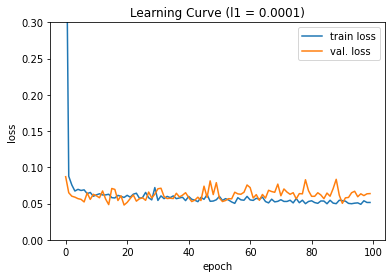

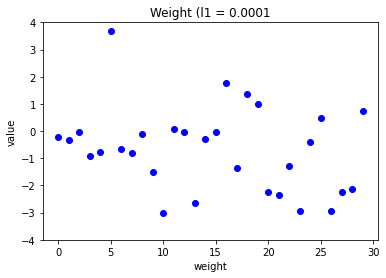

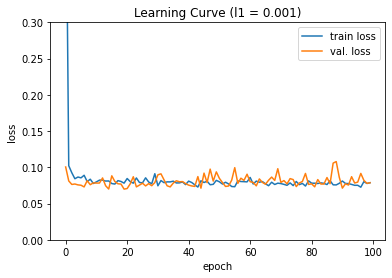

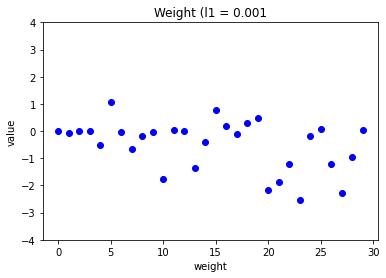

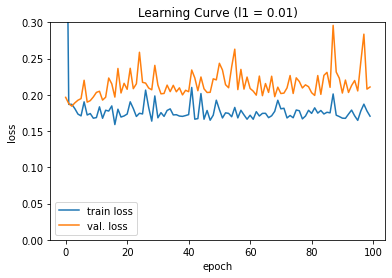

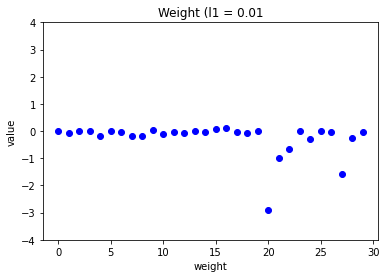

In [31]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
  layer = SingleLayer(_l1 = l1)
  layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)
  
  plt.plot(layer.losses)
  plt.plot(layer.val_losses)
  plt.title('Learning Curve (l1 = {})'.format(l1))
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.ylim(0, 0.3)
  plt.legend(['train loss', 'val. loss'])
  plt.show()

  plt.plot(layer.w, 'bo')
  plt.title('Weight (l1 = {}'.format(l1))
  plt.xlabel('weight')
  plt.ylabel('value')
  plt.ylim(-4, 4)
  plt.show()

In [40]:
layer5 = SingleLayer(_l1 = 0.001)
layer5.fit(x_train_scaled, y_train, epochs = 20)

print(layer5.score(x_val_scaled, y_val))
# 데이터 세트가 작아서 규제 효과가 크게 나타나지 않음

0.978021978021978


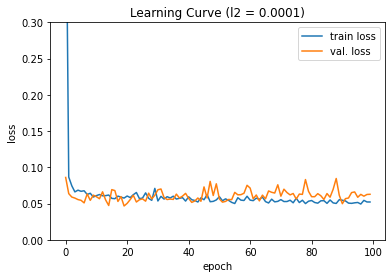

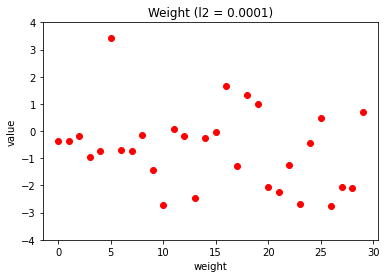

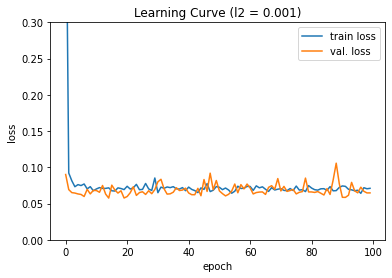

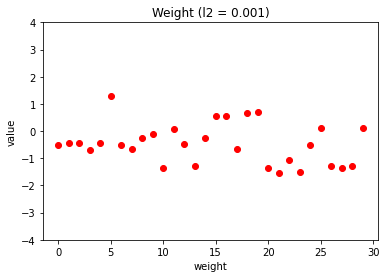

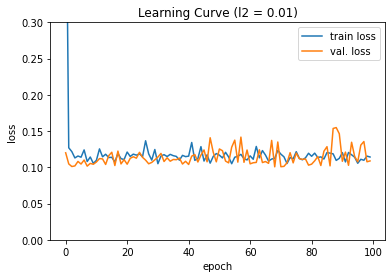

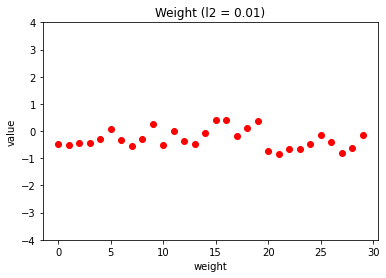

In [42]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  layer = SingleLayer(_l2 = l2)
  layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)
  
  plt.plot(layer.losses)
  plt.plot(layer.val_losses)
  plt.title('Learning Curve (l2 = {})'.format(l2))
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train loss', 'val. loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(layer.w, 'bo')
  plt.title('Weight (l2 = {})'.format(l2))
  plt.xlabel('weight')
  plt.ylabel('value')
  plt.ylim(-4, 4)
  plt.show()

In [45]:
layer6 = SingleLayer(_l2 = 0.001)
layer6.fit(x_train_scaled, y_train)

print(layer6.score(x_val_scaled, y_val))
# 데이터 세트의 샘플 개수가 아주 적어 l1 규제와 l2 규제 성능에 큰 차이가 없음

print(np.sum(layer6.predict(x_val_scaled) == y_val))
# 전체 91개 검증 샘플 중 89개의 샘플을 올바르게 예측

0.978021978021978
89


In [47]:
# 사이킷런의 SGDClassifer 사용(규제 적용)
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss = 'log', penalty = 'l2', alpha = 0.001, random_state = 42)
sgd.fit(x_train_scaled, y_train)

print(sgd.score(x_val_scaled, y_val))
# SingleLayer와 같은 결과

0.978021978021978
